# Compare all the versions of AVHRR NDVI to MODIS

In [1]:
import numpy as np
import xarray as xr
import seaborn as sb
import pandas as pd
import geopandas as gpd
from scipy import stats
import xskillscore as xs
import contextily as ctx
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_absolute_error
from matplotlib.ticker import FormatStrFormatter

import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _collect_prediction_data import round_coords

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize

# Using ggplot styles in this notebook
plt.style.use('ggplot')

%matplotlib inline

## Analysis Parameters

In [2]:
model_var='NDVI'
crs='epsg:4326'
base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/'

## Open datasets

In [11]:
avhrr = xr.open_dataset(base+model_var+'_harmonization/AVHRR_'+model_var+'_5km_monthly_1982_2013.nc')[model_var+'_avhrr']
avhrr = assign_crs(avhrr, crs=crs)
avhrr.attrs['nodata'] = np.nan

modis = xr.open_dataset(base+model_var+'_harmonization/MODIS_'+model_var+'_5km_monthly_200003_202212.nc')[model_var+'_median']
modis = assign_crs(modis, crs=crs)
modis.attrs['nodata'] = np.nan

gimms_pku = xr.open_dataset(base+model_var+'_harmonization/AVHRR_GIMMS-PKU_200003_201312.nc').rename({'__xarray_dataarray_variable__':'NDVI'})['NDVI']
gimms_pku = assign_crs(gimms_pku, crs=crs)
gimms_pku.attrs['nodata'] = np.nan

gimms = xr.open_dataset(base+model_var+'_harmonization/AVHRR_GIMMS3g_NDVI_5km_monthly_1982_2013.nc')['NDVI']
gimms = assign_crs(gimms, crs='epsg:3577')
gimms.attrs['nodata'] = np.nan

trees = xr.open_dataset(f'{base}NDVI_harmonization/LGBM/NDVI_trees_CLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
nontrees = xr.open_dataset(f'{base}/NDVI_harmonization/LGBM/NDVI_nontrees_CLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
merge = xr.where(np.isnan(trees), nontrees, trees)
merge = assign_crs(merge, crs=crs)
merge.attrs['nodata'] = np.nan
merge = merge.rename('NDVI')

avhrr_mask =  ~np.isnan(merge)
del avhrr_mask.attrs['nodata']
avhrr_mask = assign_crs(avhrr_mask, crs=crs)


## Resample datasets to match GIMMS

In [12]:
avhrr = avhrr.sel(time=slice('2001', '2013'))
modis = modis.sel(time=slice('2001', '2013'))
gimms_pku = gimms_pku.sel(time=slice('2001', '2013'))
gimms = gimms.sel(time=slice('2001', '2013'))
merge = merge.sel(time=slice('2001', '2013'))
avhrr_mask = avhrr_mask.sel(time=slice('2001', '2013'))

avhrr = avhrr.odc.reproject(gimms_pku.odc.geobox, resampling='average')
avhrr = round_coords(avhrr)

gimms = gimms.odc.reproject(gimms_pku.odc.geobox, resampling='average')
gimms = round_coords(gimms)

modis = modis.odc.reproject(gimms_pku.odc.geobox, resampling='average')
modis = round_coords(modis)

merge = merge.odc.reproject(gimms_pku.odc.geobox, resampling='average')
merge = round_coords(merge)

avhrr_mask = avhrr_mask.odc.reproject(gimms_pku.odc.geobox, resampling='mode')
avhrr_mask = round_coords(avhrr_mask)

#lat/lons are off by tiniest amount for some pixels so resample again
# gimms_pku = gimms_pku.odc.reproject(modis.odc.geobox, resampling='nearest')
gimms_pku = round_coords(gimms_pku)

In [13]:
avhrr = avhrr.where(avhrr_mask)
modis = modis.where(avhrr_mask)
gimms_pku = gimms_pku.where(avhrr_mask)
gimms = gimms.where(avhrr_mask)
merge = merge.where(avhrr_mask)

#pku has some areas masked out
pku_mask = ~np.isnan(gimms_pku)
avhrr = avhrr.where(pku_mask)
modis = modis.where(pku_mask)
merge = merge.where(pku_mask)
gimms = gimms.where(pku_mask)

In [28]:
# merge.sel(time='2011').plot.imshow(col='time', col_wrap=6, robust=True)

In [29]:
# gimms.sel(time='2011').plot.imshow(col='time', col_wrap=6, robust=True)

### Timeseries plots


#### per region

In [30]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')

Tropics
Savanna
Warm Temperate
Cool Temperate
Mediterranean
Desert


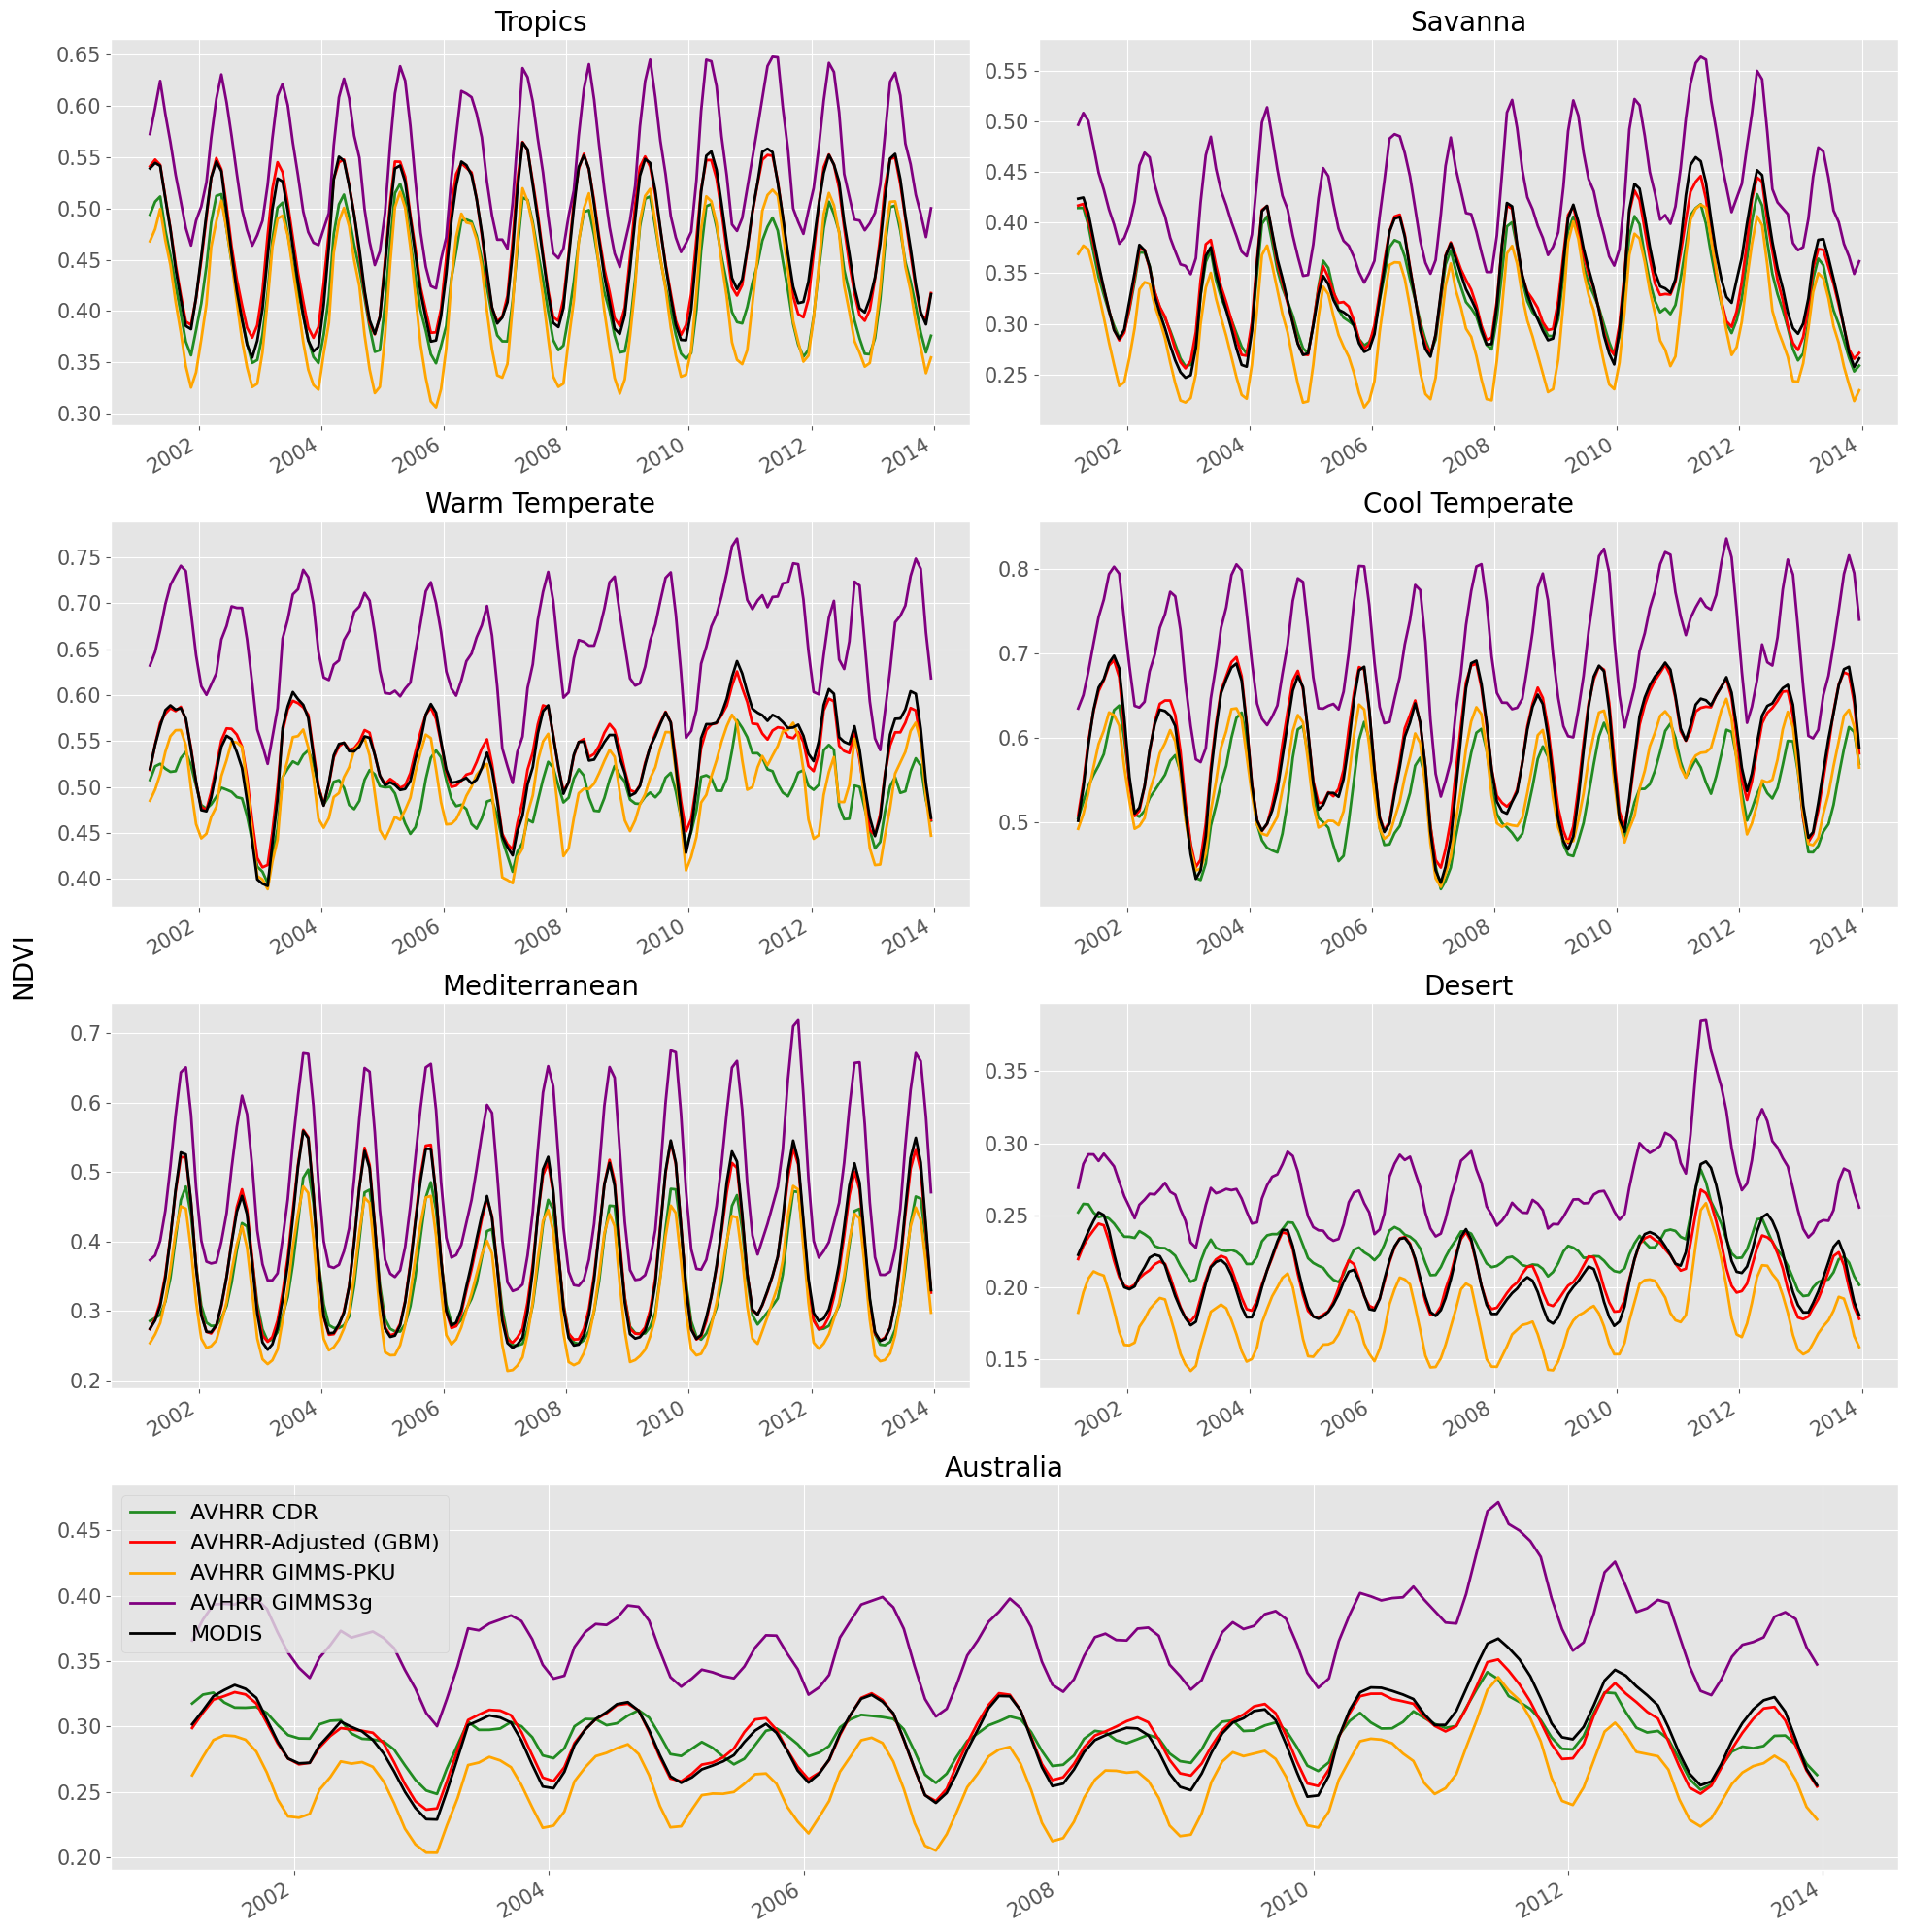

In [31]:
mosiac = [
    ["A", "B"],
    ["C", "D"],
    ["E", "F"],
    ["G", "G"],
]

fig, axes = plt.subplot_mosaic(mosiac, figsize=(20,20))

for ax, (index, row) in zip(axes, gdf.iterrows()):
    print(row['region_name'])
    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], gimms_pku, crs=crs)
    mask = round_coords(mask)
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    modis_region = modis.where(mask)
    avhrr_region = avhrr.where(mask)
    merge_region = merge.where(mask)
    gimms_pku_region = gimms_pku.where(mask)
    gimms_region = gimms.where(mask)

    avhrr_region.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes[ax], label='AVHRR CDR', c ='forestgreen', linewidth=2)
    merge_region.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes[ax], label='AVHRR adjusted (GBM)', c='red', linewidth=2)
    gimms_pku_region.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes[ax], label='AVHRR GIMMS-PKU', c='orange', linewidth=2)
    gimms_region.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes[ax], label='AVHRR GIMMS3g',c='purple', linewidth=2)
    modis_region.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes[ax], label='MODIS', c='black', linewidth=2)
    
    axes[ax].set_ylabel('')
    axes[ax].set_xlabel('')
    # axes[ax].sharex(axes['E'])
    axes[ax].tick_params(axis='y', labelsize=15)
    axes[ax].tick_params(axis='x', labelsize=15)
    axes[ax].set_title(row['region_name'], fontsize=20)
    axes[ax].grid(True)

#the last Aus-wide plot
avhrr.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes['G'], label='AVHRR CDR', c ='forestgreen', linewidth=2)
merge.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes['G'], label='AVHRR-Adjusted (GBM)', c='red', linewidth=2)
gimms_pku.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes['G'], label='AVHRR GIMMS-PKU', c='orange', linewidth=2)
gimms.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes['G'], label='AVHRR GIMMS3g',c='purple', linewidth=2)
modis.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes['G'], label='MODIS', color='black', linewidth=2)

axes['G'].set_title('Australia', fontsize=20)
axes['G'].legend(fontsize=16)
axes['G'].set_ylabel('')
axes['G'].set_xlabel('')
axes['G'].tick_params(axis='y', labelsize=15)
axes['G'].tick_params(axis='x', labelsize=15)
axes['G'].grid(True)

fig.supylabel(model_var, fontsize=20)    
plt.tight_layout(rect=(0.015,0,1,1))
fig.savefig(f'/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/{model_var}_compareallproducts_timeseries_bioregion.png',
            bbox_inches='tight', dpi=300);

### Per-pixel error metrics

In [32]:
modis_mean = modis.mean('time')
low_ndvi_mask = xr.where(modis_mean<0.10,0, 1)

In [33]:
adjusted_corr = xr.corr(modis, merge, dim='time')
adjusted_corr = adjusted_corr.where(low_ndvi_mask)

orig_corr = xr.corr(modis, avhrr, dim='time')
orig_corr = orig_corr.where(low_ndvi_mask)

adjusted_corr_pku = xr.corr(modis,gimms_pku, dim='time')
adjusted_corr_pku = adjusted_corr_pku.where(low_ndvi_mask)

adjusted_corr_gimms = xr.corr(modis,gimms, dim='time')
adjusted_corr_gimms = adjusted_corr_gimms.where(low_ndvi_mask)

adjusted_rmse_pku = xs.rmse(modis, gimms_pku, dim='time', skipna=True)
adjusted_rmse_pku = adjusted_rmse_pku.where(low_ndvi_mask)

adjusted_rmse_gimms = xs.rmse(modis, gimms, dim='time', skipna=True)
adjusted_rmse_gimms = adjusted_rmse_gimms.where(low_ndvi_mask)

adjusted_rmse = xs.rmse(modis,merge, dim='time', skipna=True)
adjusted_rmse = adjusted_rmse.where(low_ndvi_mask)

orig_rmse = xs.rmse(modis,avhrr, dim='time', skipna=True)
orig_rmse = orig_rmse.where(low_ndvi_mask)

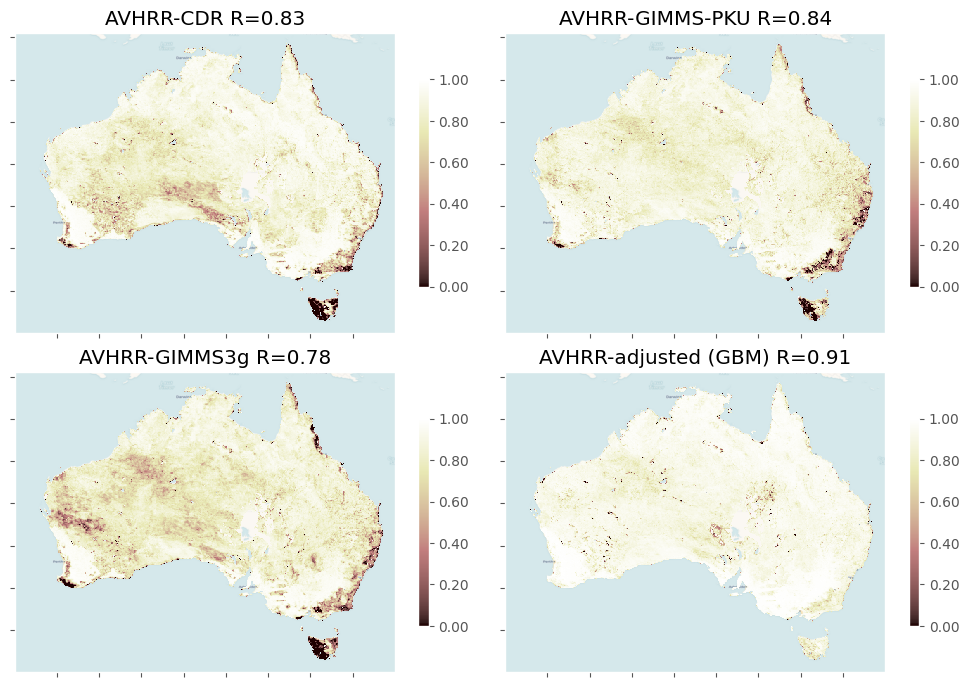

In [39]:
corr_data = [orig_corr, adjusted_corr_pku, adjusted_corr_gimms, adjusted_corr]
products=['AVHRR-CDR', 'AVHRR-GIMMS-PKU','AVHRR-GIMMS3g', 'AVHRR-adjusted (GBM)']

fig,axes = plt.subplots(2,2, figsize=(10,7), sharey=True)

for ax, ds, n in zip(axes.ravel(), corr_data, products):
    if n=='Difference':
        cmap='RdBu'
        vmin=-0.5
        vmax=0.5
    else:
        cmap='pink'
        vmin=0
        vmax=1
    im = ds.plot(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, add_colorbar=False)
    cbar = plt.colorbar(im, ax=ax, shrink=0.65)
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
    ax.set_title(f'{n} R='"{:.2f}".format(ds.mean().values))
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticklabels([])
plt.tight_layout()
fig.savefig(f'/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/{model_var}_compareallproducts_correlation_perpixel.png',
            bbox_inches='tight', dpi=300);

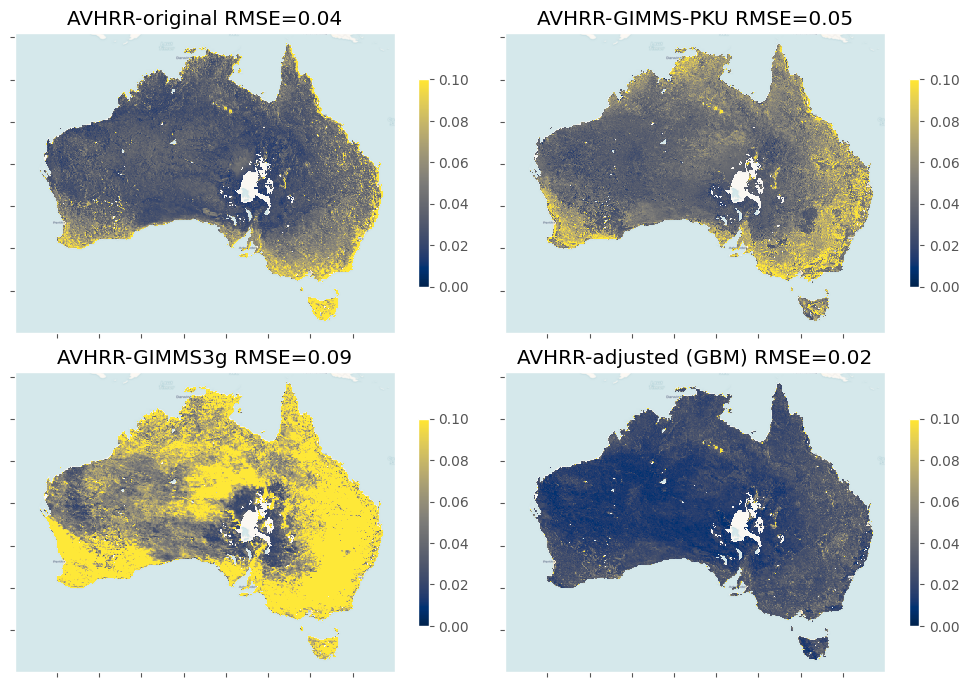

In [42]:
corr_data = [orig_rmse,  adjusted_rmse_pku, adjusted_rmse_gimms, adjusted_rmse]
products=['AVHRR-original', 'AVHRR-GIMMS-PKU','AVHRR-GIMMS3g', 'AVHRR-adjusted (GBM)']

fig,axes = plt.subplots(2,2, figsize=(10,7), sharey=True)

for ax, ds, n in zip(axes.ravel(), corr_data, products):
    if model_var=='NDVI':
        if n=='Difference':
            cmap='RdBu'
            vmin=-0.1
            vmax=0.1
        else:
            cmap='cividis'
            vmin=0.0
            vmax=0.1
    
    if model_var=='LST':
        if n=='Difference':
            cmap='RdBu'
            vmin=-6
            vmax=6
        else:
            cmap='cividis'
            vmin=0
            vmax=7.0
    im = ds.plot(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, add_colorbar=False)   
    cbar = plt.colorbar(im, ax=ax, shrink=0.65)
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(f'{n} RMSE='"{:.2f}".format(ds.mean().values))
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.tight_layout()
fig.savefig(f'/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/{model_var}_compareallproducts_rmse_perpixel.png',
            bbox_inches='tight', dpi=300);

## Residuals through time



In [64]:
#residuals after harmonization
residual = (modis - merge).mean(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='After harmonization')
residual_sd = (modis - merge).std(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='After harmonization')

residual_pku = (modis - gimms_pku).mean(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='Residuals')
residual_sd_pku = (modis - gimms_pku).std(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='Residuals')

residual_gimms = (modis - gimms).mean(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='Residuals')
residual_sd_gimms = (modis - gimms).std(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='Residuals')

# residuals before harmonization
residual_b = (modis - avhrr).mean(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='Before harmonization')
residual_sd_b = (modis - avhrr).std(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='Before harmonization')

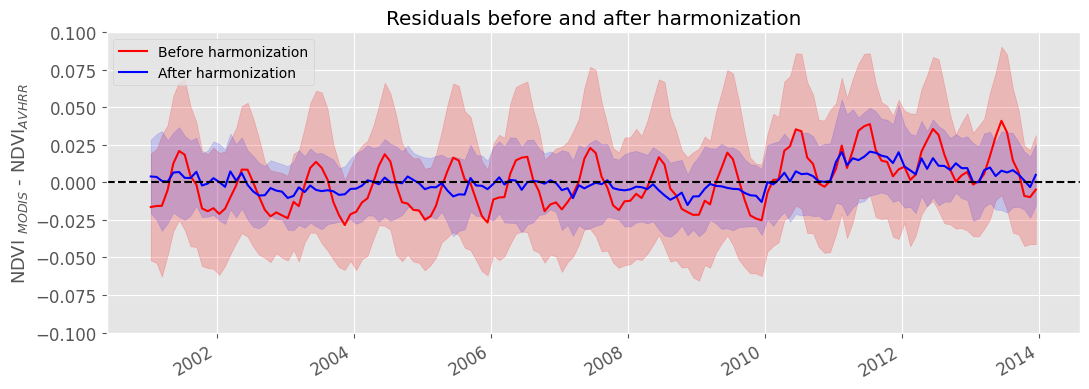

In [72]:
fig,ax = plt.subplots(1,1, figsize=(11,4), sharex=True)

residual_b.plot(ax=ax, legend=False, color='red')
ax.fill_between(residual_b.index, (residual_b-residual_sd_b)['Before harmonization'],
                   (residual_b+residual_sd_b)['Before harmonization'], alpha=0.2, color='red')

residual.plot(ax=ax, legend=False, color='blue')
ax.fill_between(residual.index, (residual-residual_sd)['After harmonization'],
                (residual+residual_sd)['After harmonization'], alpha=0.15, color='blue')

# residual_pku.plot(ax=ax[1], legend=False, color='blue')
# ax[1].fill_between(residual_pku.index, (residual_pku-residual_sd_pku)['Residuals'], (residual_pku+residual_sd_pku)['Residuals'], alpha=0.15, color='blue')

# residual_gimms.plot(ax=ax[1], legend=False, color='forestgreen')
# ax[1].fill_between(residual_gimms.index, (residual_gimms-residual_sd_gimms)['Residuals'], (residual_gimms+residual_sd_gimms)['Residuals'], alpha=0.15, color='forestgreen')

ax.axhline(0.0, color='k', linestyle='--')
ax.legend(loc='upper left')
ax.set_title('Residuals before and after harmonization')
ax.set_ylim(-0.1, 0.1)
ax.set_ylabel(model_var+" $_{MODIS}$"+ " - "+model_var+"$_{AVHRR}$", fontsize=13)
ax.set_xlabel(None)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# # ax[1].legend(['This Study', None, 'GIMMS-PKU'])
# ax[1].axhline(0.0, color='k')
# ax[1].set_title('Residuals After Harmonization')
# ax[1].set_ylim(-0.125, 0.125)
# ax[1].set_ylabel(model_var+" $_{MODIS}$"+ " - "+model_var+"$_{Cal.AVHRR}$", fontsize=13)
# ax[1].set_xlabel(None)
# ax[1].tick_params(axis='y', labelsize=12)
# ax[1].tick_params(axis='x', labelsize=12)

plt.tight_layout()
fig.savefig(f'/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/{model_var}_{feat}_residuals.png',
            bbox_inches='tight', dpi=300);